# Introduction

Prediction if the Porosity(%) of materials using their Reflectance Channels

We have limited data access

After some experiments the best approach was to:
- Use a Polyfit to create a material frequency signature (dimension reduction)
- Use Regression to predict the porosity over the frequency signature

Interesting: Smoothing did not work initially, because it smoothes also some important parts of the frequency function, which disturbs the separatin between materials. We need to implement a channel based smoothing to get rid of the noise without disturbing the actual information.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import re
import matplotlib.pyplot as plt

In [3]:
dfcont = pd.read_csv('C:/Users/joao/Downloads/BaseRoncador2019_Continuo_csv.csv', sep=';')
#dfrefc = pd.read_csv('C:/Users/joao/Downloads/BaseRoncador2019_Reflectancia_csv.csv', sep=';')

In [4]:
number_only = re.compile('^[0-9\.]+$')
bands = [col for col in dfcont.columns.values if number_only.match(col)]

In [5]:
dfcont[bands] = dfcont[bands].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

In [6]:
samples = list(dfcont['sample'].unique())

In [152]:
samples

['CR_19_001b',
 'CR_19_002b',
 'CR_19_003a',
 'CR_19_004a',
 'CR_19_005a',
 'CR_19_006a',
 'CR_19_007a',
 'CR_19_009a',
 'CR_19_010a',
 'CR_19_011b',
 'CR_19_016a',
 'CR_19_020c',
 'CR_19_023b',
 'CR_19_024c',
 'CR_19_025c',
 'CR_19_026b']

## Visualizations

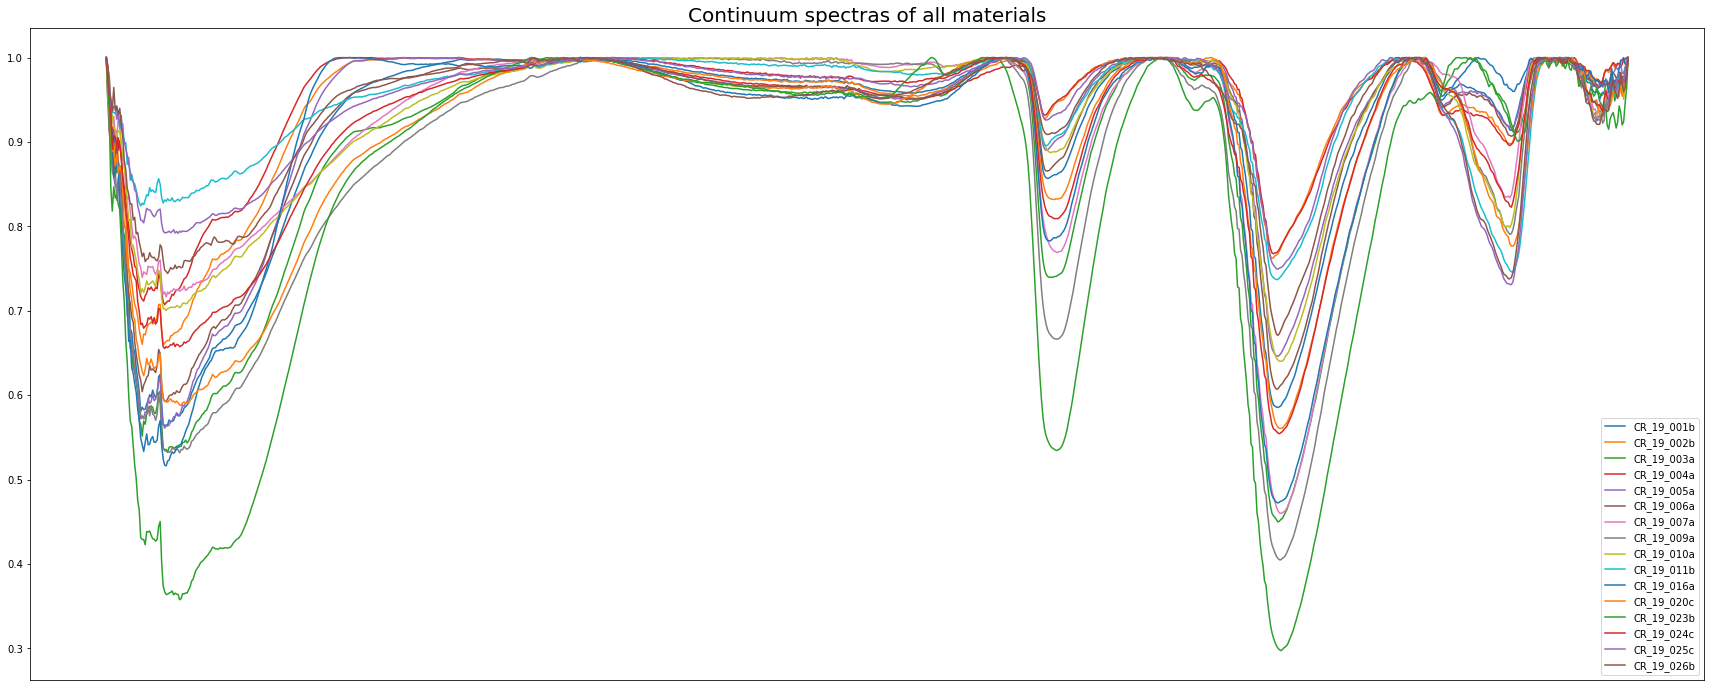

In [81]:
sample = 0
plt.figure(figsize=(30, 12))
plt.title('Continuum spectras of all materials', fontsize=20)

for material in samples:
    material_sample = dfcont[dfcont['sample'] == material].iloc[sample]
    plt.plot(bands, material_sample[bands].values, label=material)
    
plt.xticks([]) # hide X ticks
plt.legend()
plt.show()

In [ ]:
colors = ['r','g','b','k','y','m','c']
icolor = 0
plt.figure(figsize=(30, 12))
plt.title('Continuum spectra of materials samples', fontsize=20)

for material in samples:
    material_sample = dfcont[dfcont['sample'] == material]
    for i in range(len(material_sample)):
        plt.plot(bands, material_sample.iloc[i][bands].values, colors[icolor], label=str(material)+'_'+str(i))
    icolor = (icolor + 1) % len(colors)

plt.xticks([]) # hide X ticks
plt.legend()
plt.show()

## Channel Correlation

In [14]:
featureY = 'Quartz'
threshold = 0.3

In [15]:
# as vezes essa celula da erro, se rodar denovo o erro some :D
if str(dfcont[featureY].dtype) != 'float64':
    dfcont[featureY] = dfcont[featureY].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

nans_bool = np.isnan(dfcont[featureY].values)
idx_non_nan = list(dfcont[~nans_bool].index.values)
arr_corr = []
for band in bands:
    corr = np.corrcoef(dfcont[band].iloc[idx_non_nan].values, y=dfcont[featureY].iloc[idx_non_nan].values)[0,1]
    arr_corr.append(corr)

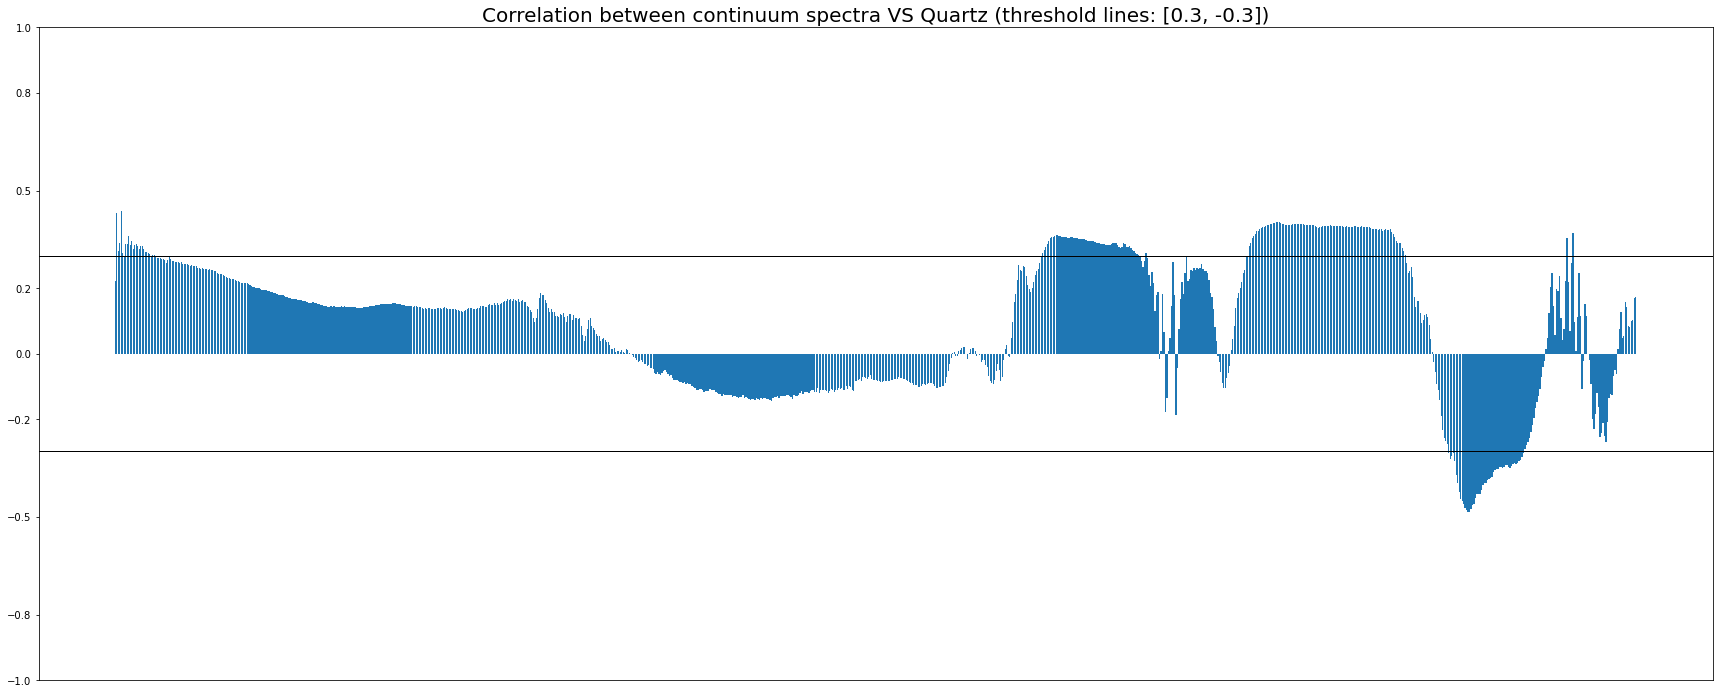

In [16]:
plt.figure(figsize=(30, 12))
plt.title('Correlation between continuum spectra VS '+str(featureY)+' (threshold lines: '+str([threshold,-threshold])+')', fontsize=20)
plt.bar(bands, arr_corr)
plt.xticks([])
plt.axhline(y=threshold,linewidth=1, color='k')
plt.axhline(y=-threshold,linewidth=1, color='k')
plt.yticks([1.0,0.8,0.5,0.2,0.0,-0.2,-0.5,-0.8,-1.0])
plt.show()

# Signature Experiments

## Frequency signature with Regression

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
# normalize X
X = [[x] for x in list(range(0,len(bands)))]
#X = np.asarray(bands).astype(float)

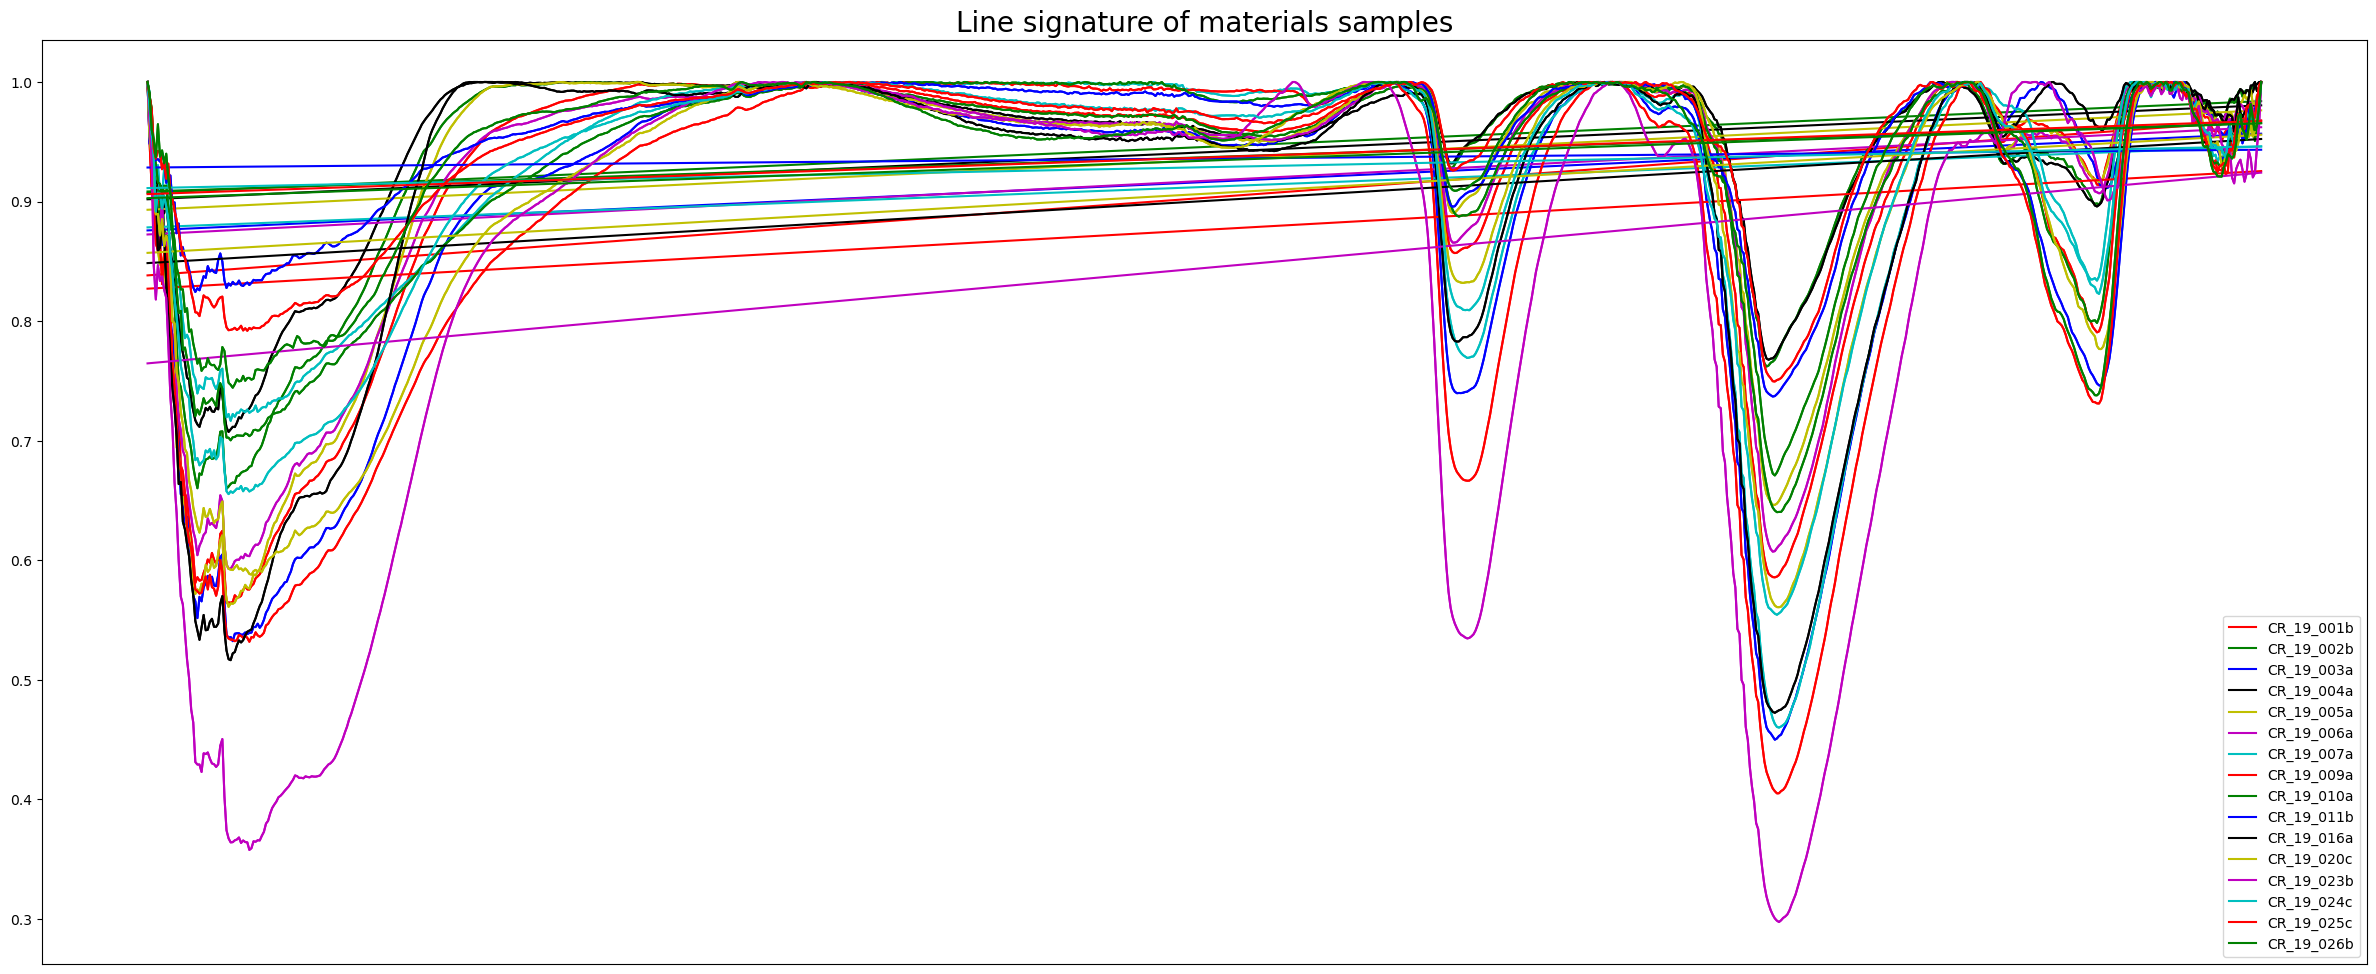

In [9]:
colors = ['r','g','b','k','y','m','c']
icolor = 0
plt.figure(figsize=(30, 12))
plt.title('Line signature of materials samples', fontsize=20)
signatures = {}
for material in samples:
    material_sample = dfcont[dfcont['sample'] == material][bands].values.astype(float)
    intercepts = []
    coefs = []
    
    for i in range(len(material_sample)):
        reg = LinearRegression().fit(X, material_sample[i])
        intercepts.append(reg.intercept_)
        coefs.append(reg.coef_[0])
    
    signatures[material] = [intercepts, coefs]
    
    y_pred_mean = np.mean(intercepts) + np.mean(coefs)*np.asarray(X)
    plt.plot(bands, material_sample[0], colors[icolor], label=str(material))
    plt.plot(bands, material_sample[0], colors[icolor])
    plt.plot(bands, y_pred_mean, colors[icolor])
    icolor = (icolor + 1) % len(colors)

plt.xticks([]) # hide X ticks
plt.legend()
plt.show()

In [56]:
dict_to_df = []
for material in signatures:
    ss = signatures[material]
    for i in range(len(ss[0])):
        dict_to_df.append({'material':material,'intercept':ss[0][i],'coef':ss[1][i]})

In [59]:
df_signatures = pd.DataFrame.from_records(dict_to_df)

In [70]:
df_signatures

,material,intercept,coef
0,CR_19_001b,0.859061,0.000117
1,CR_19_001b,0.828517,0.000127
2,CR_19_001b,0.837581,0.000124
3,CR_19_001b,0.817426,0.000167
4,CR_19_001b,0.839048,0.000116
...,...,...,...
103,CR_19_026b,0.912758,0.000043
104,CR_19_026b,0.946096,0.000017
105,CR_19_026b,0.848138,0.000125
106,CR_19_026b,0.902474,0.000070


In [100]:
featureY = 'Porosidade (%)'

In [101]:
# as vezes essa celula da erro, se rodar denovo o erro some :D
if str(dfcont[featureY].dtype) != 'float64':
    dfcont[featureY] = dfcont[featureY].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

nans_bool = np.isnan(dfcont[featureY].values)
idx_non_nan = list(dfcont[~nans_bool].index.values)

corr = np.corrcoef(df_signatures['intercept'].iloc[idx_non_nan].values, y=dfcont[featureY].iloc[idx_non_nan].values)
print(corr)
corr = np.corrcoef(df_signatures['coef'].iloc[idx_non_nan].values, y=dfcont[featureY].iloc[idx_non_nan].values)
print(corr)

[[ 1.         -0.53143936]
 [-0.53143936  1.        ]]
[[1.         0.57188673]
 [0.57188673 1.        ]]


## Smoothing the signals

In [14]:
from math import factorial

In [17]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    #https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [10]:
y = dfcont[dfcont['sample'] == 'CR_19_001b'][bands].values.astype(float)

In [223]:
def smooth_by_parts(y):
    yhat1 = savitzky_golay(y[:560], 51, 2)
    yhat2 = savitzky_golay(y[560:], 21, 2)
    #yhat3 = savitzky_golay(y[700:], 21, 2)
    return np.concatenate([yhat1, yhat2])

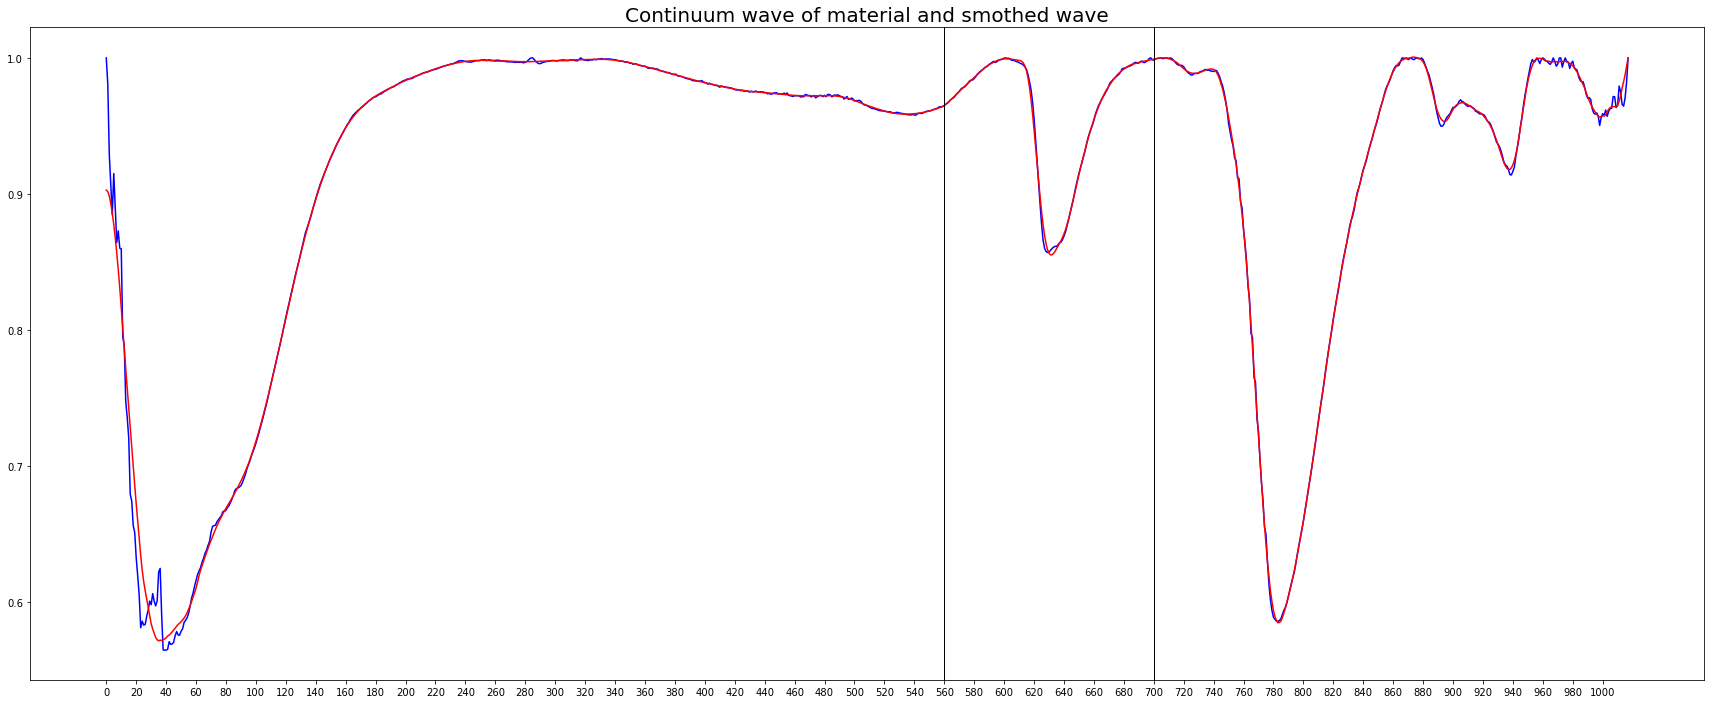

In [224]:
yhat = smooth_by_parts(y[0])
plt.figure(figsize=(30, 12))
plt.title('Continuum wave of material and smothed wave', fontsize=20)
plt.plot(range(0, len(bands)), y[0], 'b')
plt.plot(range(0, len(bands)), yhat, 'r')
plt.xticks(range(0, len(bands), 20)) # hide X ticks
plt.axvline(x=560,linewidth=1, color='k')
plt.axvline(x=700,linewidth=1, color='k')
plt.show()

## Frquency Signature with a polinomial function (Polyfit)

In [10]:
Xpoly = np.asarray(bands).astype(float)

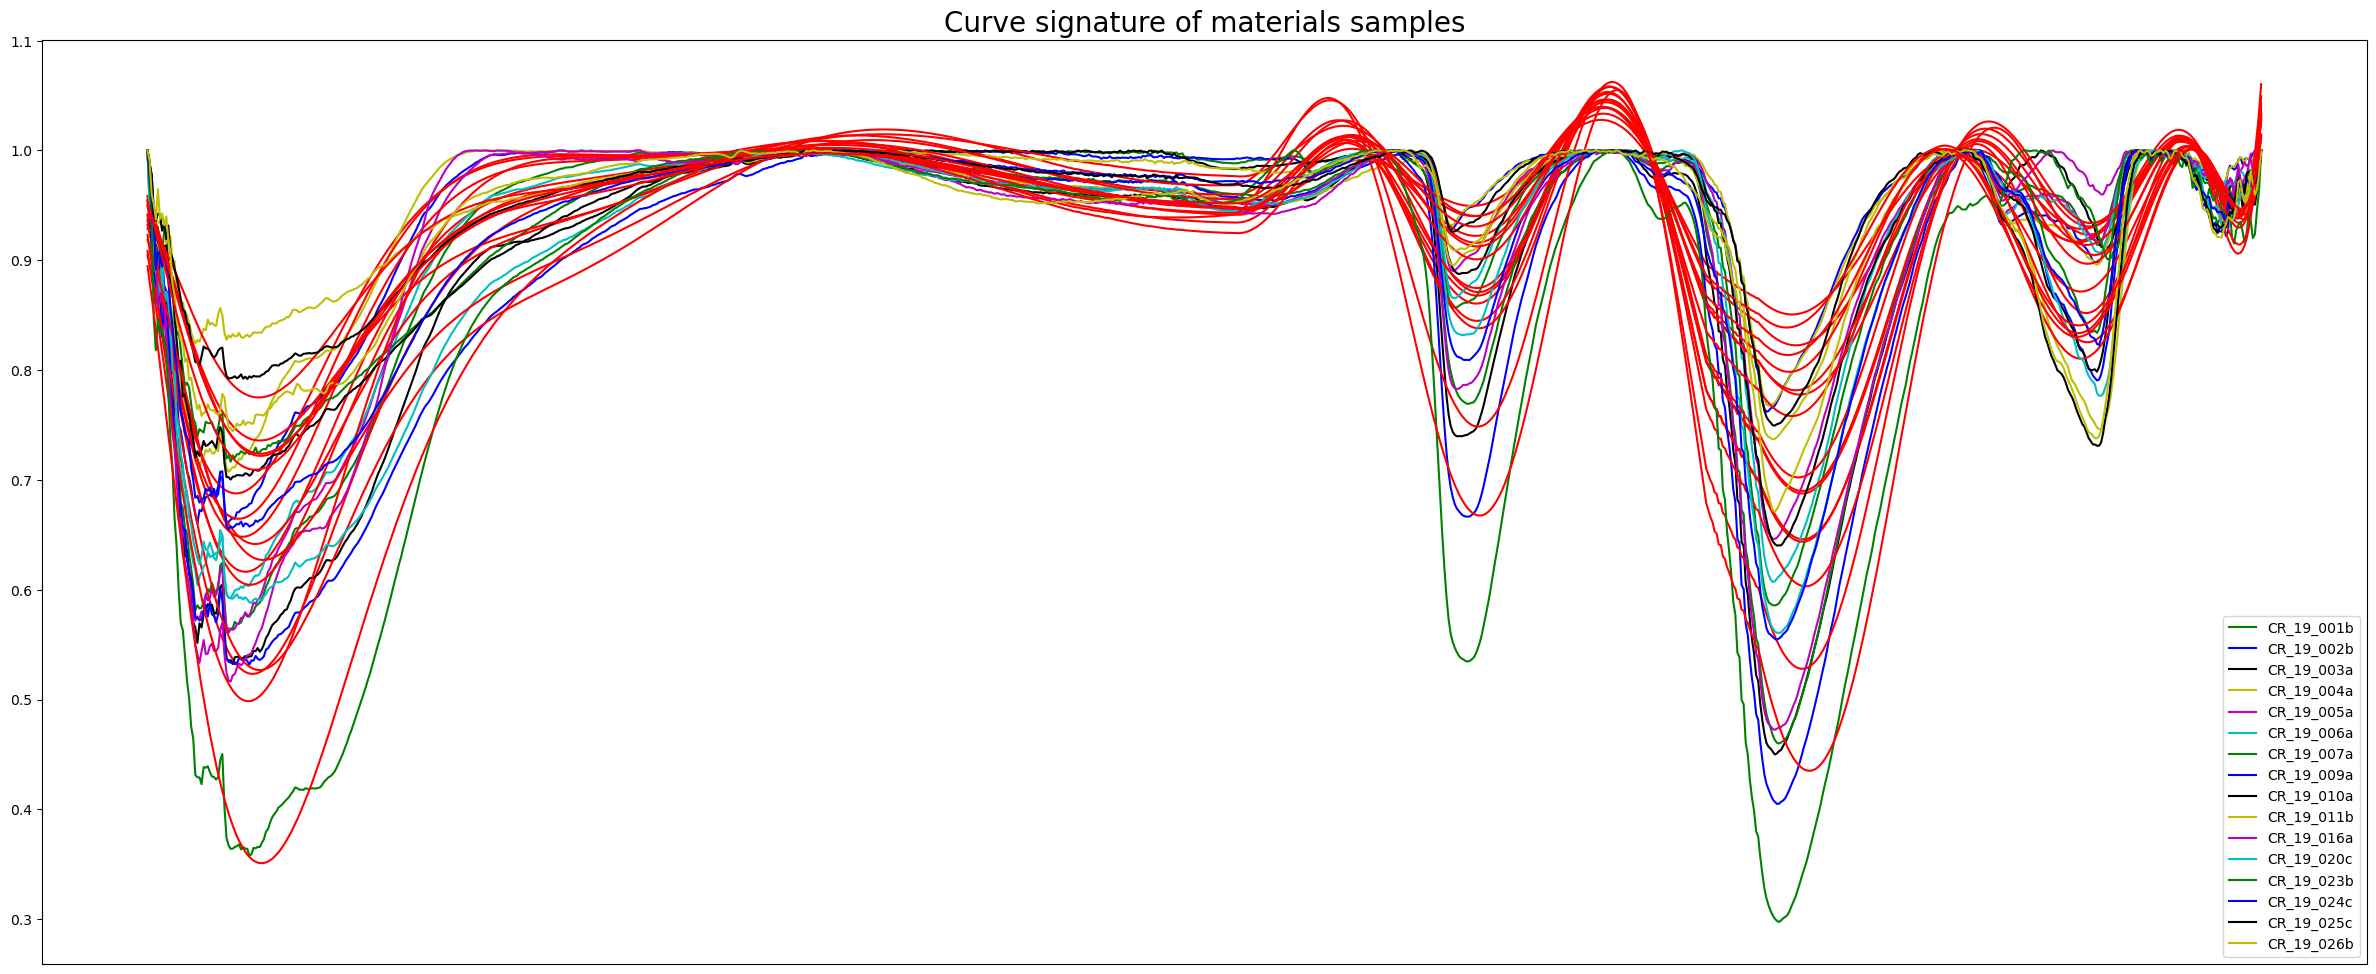

In [11]:
colors = ['g','b','k','y','m','c']
icolor = 0
degreee = 15
plt.figure(figsize=(30, 12))
plt.title('Curve signature of materials samples', fontsize=20)
signatures = {}
for material in samples:
    Ypoly = dfcont[dfcont['sample'] == material][bands].values.astype(float)
    coefs = [[] for i in range(degreee+1)]

    for i in range(len(Ypoly)):
        #coef = np.polyfit(Xpoly, smooth_by_parts(Ypoly[i]), degreee)
        coef = np.polyfit(Xpoly, Ypoly[i], degreee)
        for j in range(len(coefs)):
            coefs[j].append(coef[j])
        #fn = np.poly1d(coef)
        #plt.plot(bands, Ypoly[i], 'b', label=str(material)+'_'+str(i))
        #plt.plot(bands, fn(Xpoly), 'r')

    signatures[material] = coefs
    coef_mean = [np.mean(coefs[i]) for i in range(len(coefs))]
    fn = np.poly1d(coef_mean)
    
    plt.plot(bands, Ypoly[0], colors[icolor], label=str(material))
    plt.plot(bands, fn(Xpoly), 'r')
    icolor = (icolor + 1) % len(colors)
    
plt.xticks([]) # hide X ticks
plt.legend()
plt.show()

In [12]:
dict_to_df = []
for material in signatures:
    ss = signatures[material]
    for i in range(len(ss[0])):
        dicct = {'material':material}
        for j in range(len(ss)):
            dicct['coef'+str(j+1)] = ss[j][i]
        dict_to_df.append(dicct)

In [13]:
df_signatures = pd.DataFrame.from_records(dict_to_df)

In [ ]:
df_signatures

In [16]:
featureY = 'Porosidade (%)'

In [17]:
# as vezes essa celula da erro, se rodar denovo o erro some :D
if str(dfcont[featureY].dtype) != 'float64':
    dfcont[featureY] = dfcont[featureY].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

nans_bool = np.isnan(dfcont[featureY].values)
idx_non_nan = list(dfcont[~nans_bool].index.values)

arr_corr = []
for i in range(degreee):
    corr = np.corrcoef(df_signatures['coef'+str(i+1)].iloc[idx_non_nan].values, y=dfcont[featureY].iloc[idx_non_nan].values)[0,1]
    arr_corr.append(corr)

In [ ]:
plt.figure(figsize=(30, 12))
plt.title('Correlation between continuum spectra VS '+str(featureY), fontsize=20)
plt.bar(list(range(degreee)), arr_corr)
plt.yticks([1.0,0.8,0.5,0.2,0.0,-0.2,-0.5,-0.8,-1.0])
plt.show()

# Prediction Experiments

## Regression over the Signature

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
coefs = ['coef'+str(i+1) for i in range(degreee)]
coefs = coefs[:-2]

# ['intercept','coef']
Xreg = df_signatures[coefs].iloc[idx_non_nan].values
Yreg = dfcont[featureY].iloc[idx_non_nan].values

X_train, X_test, y_train, y_test = train_test_split(Xreg, Yreg, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(75, 13) (19, 13)


In [232]:
reg = LinearRegression().fit(X_train, y_train)

In [233]:
scr = reg.score(X_test, y_test)
print('Score (R2):', scr)

Score (R2): 0.788207133525979


In [238]:
outs = reg.predict(X_test)

In [242]:
mse = mean_squared_error(y_test, outs)
print('MSE:', mse)
mae = mean_absolute_error(y_test, outs)
print('MAE:', mae)

MSE: 18.183627798221192
MAE: 2.9713062642584696


In [239]:
print(f"Predicted \t\t Truth \t Error")
mean_err = []
for i in range(len(outs)):
    err = outs[i]-y_test[i]
    mean_err.append(err)
    print(f"{outs[i]} \t {y_test[i]} \t {err}")
    
print('Median error: ', np.mean(mean_err))
print('Median error: ', np.median(mean_err))

Predicted 		 Truth 	 Error
19.903975945123562 	 21.92 	 -2.016024054876439
19.821434391012314 	 20.39 	 -0.5685656089876865
10.896870933302878 	 11.43 	 -0.5331290666971213
19.80477890007601 	 18.47 	 1.3347789000760102
20.156776637371365 	 19.52 	 0.6367766373713657
12.352417361837345 	 4.22 	 8.132417361837344
4.112516099732776 	 4.22 	 -0.10748390026722365
25.33929117858589 	 35.87 	 -10.530708821414109
20.34577884326059 	 20.39 	 -0.04422115673941107
27.218212246280316 	 35.87 	 -8.651787753719681
7.567756931987753 	 10.0 	 -2.432243068012247
17.990263309162543 	 19.52 	 -1.5297366908374563
13.7819623832678 	 12.88 	 0.901962383267799
11.9822350470755 	 6.07 	 5.9122350470755
9.975876693479979 	 6.07 	 3.9058766934799785
8.665278318482105 	 4.22 	 4.445278318482106
17.67050551843794 	 19.52 	 -1.8494944815620613
20.542489268746152 	 19.1 	 1.4424892687461508
8.520390192538773 	 10.0 	 -1.4796098074612267
Median error:  -0.1595363052757058
Median error:  -0.10748390026722365


{'whiskers': [<matplotlib.lines.Line2D at 0x1e0767ffc40>,
 'caps': [<matplotlib.lines.Line2D at 0x1e0767c63a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e0767ff100>],
 'medians': [<matplotlib.lines.Line2D at 0x1e0767c6ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e0767c6e50>],
 'means': []}

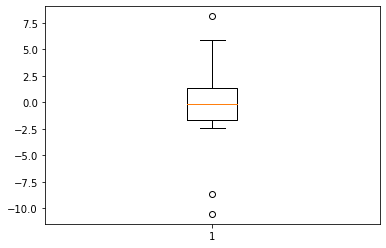

In [236]:
plt.boxplot(mean_err)

## RandomForest over the Signature

In [401]:
from sklearn.ensemble import RandomForestRegressor

In [402]:
rf = RandomForestRegressor(n_estimators=500, random_state=0)

In [404]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

In [410]:
rf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12440239, 0.87559761])

In [407]:
pred = rf.predict(X_test)

In [414]:
r2 = r2_score(y_test, pred)
print('R2:', r2)
mse = mean_squared_error(y_test, pred)
print('MSE:', mse)
mae = mean_absolute_error(y_test, pred)
print('MAE:', mae)

R2: -0.0032727271344306086
MSE: 86.13669645269455
MAE: 6.400350526315779


## SVM over the Signature

In [416]:
from sklearn.svm import SVR

In [417]:
svm = SVR(C=10, gamma=5, kernel='rbf', epsilon=0.01)

In [418]:
svm.fit(X_train, y_train)

SVR(C=10, epsilon=0.01, gamma=5)

In [419]:
score = svm.score(X_test, y_test)

In [421]:
print('Score (R2):', score)

Score (R2): -0.08411797056457582


In [422]:
outs = svm.predict(X_test)

In [423]:
mse = mean_squared_error(y_test, outs)
print('MSE:', mse)
mae = mean_absolute_error(y_test, outs)
print('MAE:', mae)

MSE: 93.0777225611951
MAE: 7.526315976455725


## DNN over the Signature

In [19]:
import tensorflow as tf
from tensorflow import keras

In [20]:
model = keras.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=X_train[0].shape),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),'mean_squared_error','mean_absolute_error'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dense_3 (Dense)             (None, 10)                160       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,006
Trainable params: 1,006
Non-trainable params: 0
_________________________________________________________________


In [398]:
history = model.fit(X_train, y_train, epochs=100, batch_size=3, verbose=0)

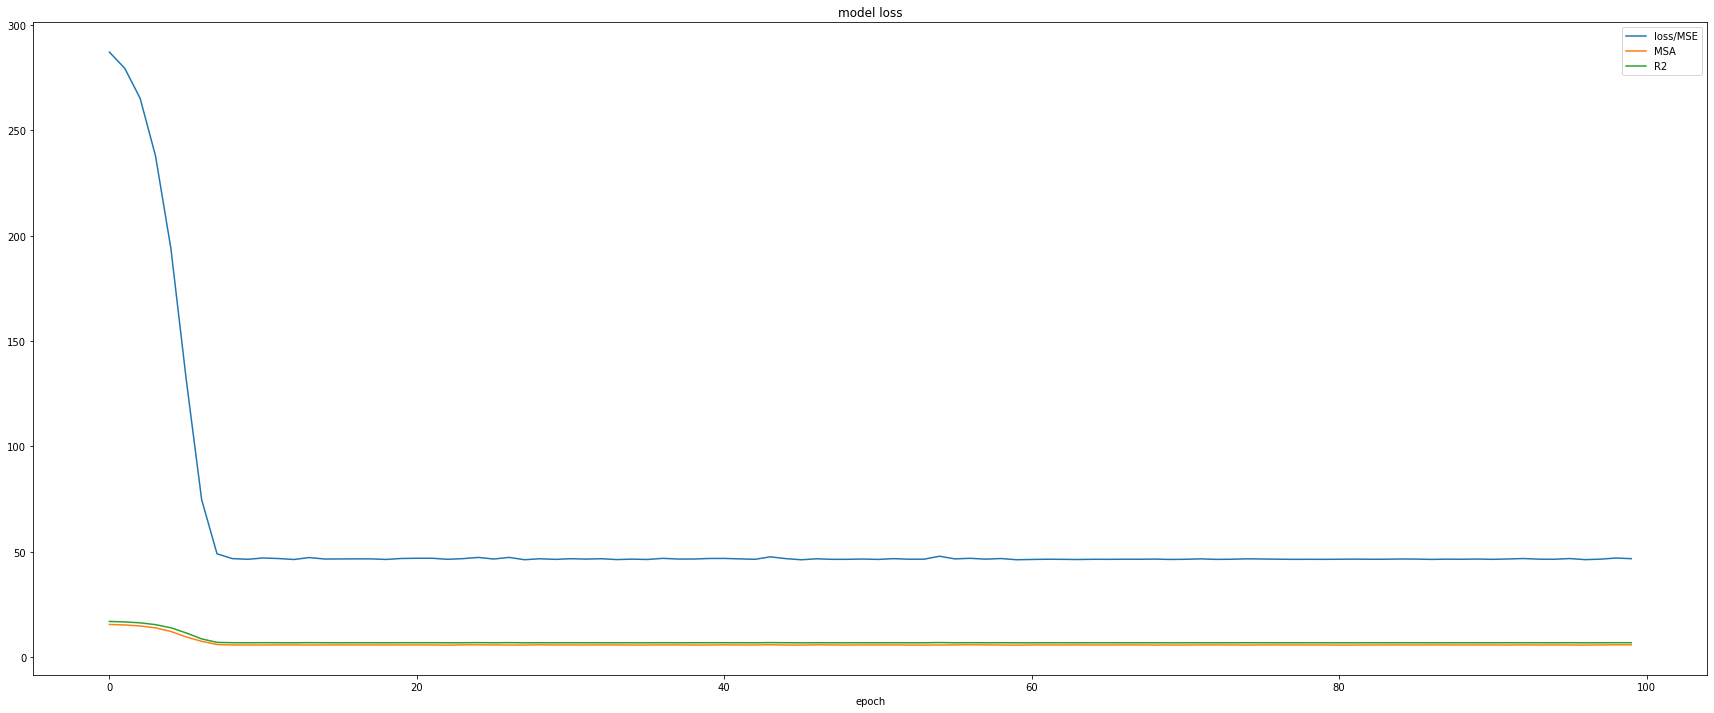

In [399]:
plt.figure(figsize=(30, 12))
plt.plot(history.history['mean_squared_error'], label='loss/MSE')
plt.plot(history.history['mean_absolute_error'], label='MSA')
plt.plot(history.history['root_mean_squared_error'], label='R2')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [400]:
score = model.evaluate(X_test, y_test)
print('R2:', score[1])
print('MSE:', score[2])
print('MAE:', score[3])

1/1 [==============================] - 0s 124ms/step - loss: 85.8295 - root_mean_squared_error: 9.2644 - mean_squared_error: 85.8295 - mean_absolute_error: 7.6763
R2: 9.264422416687012
MSE: 85.82952880859375
MAE: 7.676321506500244
